In [1]:
# pip install numpy pandas matplotlib seaborn scikit-learn

In [2]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_absolute_error

In [3]:
#Load the data
df = pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
#To observe Nan values
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

Society and balcony are having more nan values so these columns are unwanted

In [6]:
#Drop unwanted columns
columns_to_remove = ["area_type","availability","society","balcony"]
df = df.drop(columns_to_remove,axis=1)
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [7]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

Handling Nan values

In [8]:
#Handling missing values in Location column
df['location'].value_counts()
df['location'] = df['location'].fillna("Sarjapur  Road")

In [9]:
#Handling missing values in size column
df['size'] = df['size'].fillna("2 BHK")

In [10]:
#Handling missing values in bath column

median = df['bath'].median()

df['bath'] = df['bath'].fillna(median)


In [11]:
#cleaning size column and converting into integer

out = [int(i.split()[0]) for i in df['size']]
df['bhk'] = out

In [12]:
#outlier observation in bhk
df[df['bhk']>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [13]:
#clean Total sqft column
def convert(a):
    l = a.split('-')
    if len(l)==2:
        return float(l[0])+float(l[1])/2
    try:
        return float(a)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert)

In [14]:
df['total_sqft'].unique()

array([1056., 2600., 1440., ..., 2758.,  774., 4689.], shape=(2000,))

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13320 non-null  object 
 1   size        13320 non-null  object 
 2   total_sqft  13274 non-null  float64
 3   bath        13320 non-null  float64
 4   price       13320 non-null  float64
 5   bhk         13320 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 624.5+ KB


In [16]:
#creating price per sqft column

df['price_per_sqft'] =  df['price']*100000/df['total_sqft']

In [17]:
#clean location column
df['location'] = df['location'].apply(lambda x: x.strip())
loc_lessthan_10 = df['location'].value_counts()

loc_lessthan_10 = loc_lessthan_10[loc_lessthan_10<=10]
loc_lessthan_10

location
Dodsworth Layout         10
Nagadevanahalli          10
Sadashiva Nagar          10
1st Block Koramangala    10
Gunjur Palya             10
                         ..
Hsr layout sector3        1
Thyagraj Nagar            1
Banagirinagar             1
Medaralli                 1
Chikkajala                1
Name: count, Length: 1053, dtype: int64

In [18]:
df['location'] = df['location'].apply(lambda x: "other" if x in loc_lessthan_10 else x)
df['location'].value_counts()

location
other                        2885
Whitefield                    541
Sarjapur  Road                400
Electronic City               304
Kanakpura Road                273
                             ... 
Tindlu                         11
Marsur                         11
2nd Phase Judicial Layout      11
Thyagaraja Nagar               11
HAL 2nd Stage                  11
Name: count, Length: 242, dtype: int64

Detecting and Handling outliers

In [19]:
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,13274.000000,13320.000000,13320.000000,13320.000000,1.327400e+04
mean,1572.225941,2.688814,112.565627,2.802778,7.883254e+03
std,1254.823072,1.338754,148.971674,1.294496,1.064303e+05
min,1.000000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.000000,2.000000,50.000000,2.000000,4.227642e+03
50%,1280.000000,2.000000,72.000000,3.000000,5.416667e+03
75%,1690.000000,3.000000,120.000000,3.000000,7.293505e+03
max,52272.000000,40.000000,3600.000000,43.000000,1.200000e+07


Min value in total_sqft column is 1. in realtime we can't have a room with 1 total_sqft
as per real estate valid minimum total_sqft should be 300

In [20]:
#Extract the data where total sqft is  more than 300

df = df[df['total_sqft']/df['bhk']>=300]
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000
mean,1607.911902,2.559537,111.382401,2.650838,6278.292738
std,1277.977557,1.077938,152.077329,0.976678,4171.053803
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1120.000000,2.000000,49.000000,2.000000,4177.777778
50%,1302.500000,2.000000,70.000000,3.000000,5273.281068
75%,1710.000000,3.000000,115.000000,3.000000,6896.551724
max,52272.000000,16.000000,3600.000000,16.000000,176470.588235


Now here we have min total sqft as 300

In [21]:
#To keep realistic rows where the total sqft is atleast 300 as per each bhk  value

df = df[df['total_sqft']>=df['bhk']*300]
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12530.000000,12530.000000,12530.000000,12530.000000,12530.000000
mean,1607.911902,2.559537,111.382401,2.650838,6278.292738
std,1277.977557,1.077938,152.077329,0.976678,4171.053803
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1120.000000,2.000000,49.000000,2.000000,4177.777778
50%,1302.500000,2.000000,70.000000,3.000000,5273.281068
75%,1710.000000,3.000000,115.000000,3.000000,6896.551724
max,52272.000000,16.000000,3600.000000,16.000000,176470.588235


<Axes: xlabel='price_per_sqft'>

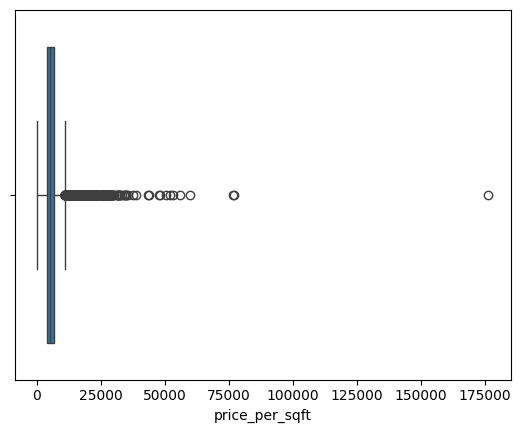

In [22]:
sns.boxplot(x="price_per_sqft",data=df)

In [23]:
#Handling outliers in price_per_sqft column
q1 = df['price_per_sqft'].quantile(0.25)
q3 = df['price_per_sqft'].quantile(0.75)

IQR = q3-q1

lower_bound = q1-0.5*IQR
upper_bound = q3+0.5*IQR

df = df[(df['price_per_sqft']>=lower_bound) & (df['price_per_sqft']<=upper_bound)]

<Axes: xlabel='price_per_sqft'>

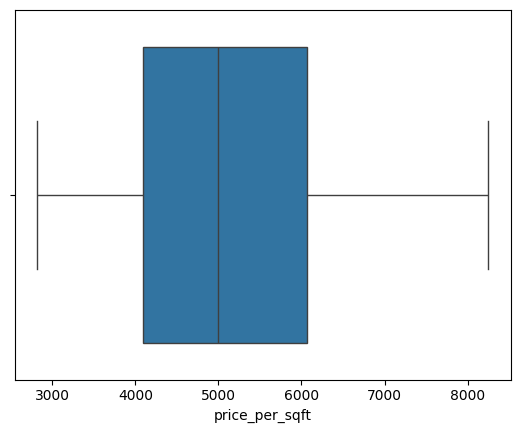

In [24]:
sns.boxplot(x="price_per_sqft",data=df)

In [25]:
#Handling outliers in bhk
df = df[df['bhk']<=6]

In [26]:
#Handling outliers in bath column
#keep rows where no.of bath is reasonable
df = df[df['bath']<df['bhk']+2]

#It removes unrealistic rows where no.of bath is suspiciously high compared to no.of bedrooms (bhk)
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,10220.000000,10220.000000,10220.000000,10220.000000,10220.000000
mean,1446.128187,2.368395,76.464815,2.497358,5138.603192
std,804.867504,0.780173,55.095591,0.754471,1315.646721
min,300.000000,1.000000,10.000000,1.000000,2820.512821
25%,1100.000000,2.000000,47.000000,2.000000,4090.909091
50%,1260.000000,2.000000,64.000000,2.000000,5000.000000
75%,1590.000000,3.000000,89.552500,3.000000,6060.898561
max,30400.000000,7.000000,2100.000000,6.000000,8250.000000


In [27]:
#Removing unwanted columns

df = df.drop(['size','price_per_sqft'],axis=1)
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [28]:
df.reset_index(inplace=True)
df = df.drop("index",axis=1)
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [29]:
cleaned = df.copy()

Machine Learning

In [30]:
#Encoding on Location column
encoder = LabelEncoder()
df['location'] = encoder.fit_transform(df['location'])
df.head()

,location,total_sqft,bath,price,bhk
0,78,1056.0,2.0,39.07,2
1,60,2600.0,5.0,120.00,4
2,225,1440.0,2.0,62.00,3
3,158,1521.0,3.0,95.00,3
4,150,1200.0,2.0,51.00,2


In [31]:
#Dividing the data into input and output features
X = df.drop("price",axis=1)
y = df['price']

In [32]:
#Splitting the data into training and testing data
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=42)

In [33]:
model = RandomForestRegressor(random_state=42)

params = {
    'n_estimators':[100,150,200,250,300],
     'max_depth':[3,4,5,6]
}
grid = GridSearchCV(estimator=model,param_grid=params)
grid.fit(Xtrain,ytrain)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [34]:
print("Training Efficiency: ",grid.score(Xtrain,ytrain))
print("Testing Efficiency: ",grid.score(Xtest,ytest))

Training Efficiency:  0.8858619680331917
Testing Efficiency:  0.82334498695281


In [35]:
print("Best params: ",grid.best_params_)
print("Best Score: ",grid.best_score_)

Best params:  {'max_depth': 6, 'n_estimators': 150}
Best Score:  0.8282112313068752


In [36]:
ypred = grid.predict(Xtest)

In [37]:
print("R2: ",r2_score(ytest,ypred))
print("MAE: ",mean_absolute_error(ytest,ypred))

R2:  0.82334498695281
MAE:  14.30569775599234


In [38]:
#Saving the model into pickle file
with open("RF_Model.pkl",'wb') as file:
    pickle.dump(grid,file)

In [39]:
df.head()

,location,total_sqft,bath,price,bhk
0,78,1056.0,2.0,39.07,2
1,60,2600.0,5.0,120.00,4
2,225,1440.0,2.0,62.00,3
3,158,1521.0,3.0,95.00,3
4,150,1200.0,2.0,51.00,2


In [45]:
cleaned['encoded_loc']  = df['location']
cleaned

,location,total_sqft,bath,price,bhk,encoded_loc
0,Electronic City Phase II,1056.0,2.0,39.07,2,78
1,Chikka Tirupathi,2600.0,5.0,120.00,4,60
2,Uttarahalli,1440.0,2.0,62.00,3,225
3,Lingadheeranahalli,1521.0,3.0,95.00,3,158
4,Kothanur,1200.0,2.0,51.00,2,150
...,...,...,...,...,...,...
10215,Uttarahalli,1345.0,2.0,57.00,3,225
10216,Green Glen Layout,1715.0,3.0,112.00,3,86
10217,Whitefield,3453.0,4.0,231.00,5,234
10218,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,193


In [46]:
cleaned.to_csv("cleaned.csv")